### testの方も完全なwifiベースでデータセットを作成
testのreal timestampは公開notebookのものに変更
kalman filterでwaypointを補完する　

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, wait, LocalCluster
from pathlib import Path
import warnings
warnings.simplefilter('ignore')

In [2]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [3]:
train_df = from_pickle('../input/2kaido_wifi_dataset_v3/train_10000_7.pkl')
train_df['wifi_timestamp'] = (train_df['timestamp'].astype(int) - train_df['timediff'].astype(int)).astype(str)
train_df['site_path_timestamp'] = train_df['site_id'] + "_" + train_df['path'] + "_" + train_df['timestamp']
train_df = train_df.reset_index().rename(columns={'index':'id'})
train_df = train_df[['site_path_timestamp','id','path', 'wifi_timestamp']]
train_df

,site_path_timestamp,id,path,wifi_timestamp
0,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,0,5e1580d1f4c3420006d520e4,1578466134323
1,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,1,5e1580d1f4c3420006d520e4,1578466136290
2,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,2,5e1580d1f4c3420006d520e4,1578466138249
3,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,3,5e1580d1f4c3420006d520e4,1578466140206
4,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,4,5e1580d1f4c3420006d520e4,1578466142173
...,...,...,...,...
252807,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252807,5dcfb393878f3300066c70a6,1573892865962
252808,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252808,5dcfb393878f3300066c70a6,1573892867874
252809,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252809,5dcfb393878f3300066c70a6,1573892869762
252810,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252810,5dcfb393878f3300066c70a6,1573892871687


In [4]:
def create_kalman_filter_dataset(file):
    filename = file.split('/')[-1].split('.')[0]
    site = filename.split('_')[0]
    floor = filename.split('_')[1]
    path = filename.split('_')[2]

    with open(file, encoding='utf-8') as f:
        txt = f.readlines()
    timestamp = []
    x = []
    y = []
    # 1:timestamp, -2:x, -1:y
    for i, line in enumerate(txt):
        if i == 0:
            continue
        else:
            timestamp.append(line.split(',')[1])
            x.append(line.split(',')[-2])
            y.append(line.split(',')[-1].replace('\n', ''))
    df = pd.DataFrame([timestamp, x, y], index=['wifi_timestamp', 'fx', 'fy']).T

    # train datasetにmergeさせる
    fx = []
    fy = []
    fdiff = []
    path_df = train_df[train_df['path']==path].copy()
    for idx, row in path_df.iterrows():
        idx = (int(row['wifi_timestamp']) - df['wifi_timestamp'].astype(int)).abs().argsort()[0]
        
        diff = int(row['wifi_timestamp']) - int(df.loc[idx, 'wifi_timestamp'])
        fx.append(df.loc[idx, 'fx'])
        fy.append(df.loc[idx, 'fy'])
        fdiff.append(diff)
    path_df['fx'] = fx
    path_df['fy'] = fy
    path_df['ftimediff'] = fdiff
    
    del df, fx, fy,fdiff, x,y,timestamp
    gc.collect()
    return path_df[['site_path_timestamp','id','fx','fy','ftimediff']]

In [6]:
from tqdm.notebook import tqdm
from multiprocessing import Pool
from multiprocessing import cpu_count

new_train_df = pd.DataFrame()
files = sorted(glob.glob('../input/04-waypoints-calculated/*.txt'))
with Pool(24) as p:
    for path_df in tqdm(p.imap_unordered(create_kalman_filter_dataset, files), total=len(files)):
        new_train_df = pd.concat([new_train_df, path_df], axis=0)

  0%|          | 0/10877 [00:00<?, ?it/s]

In [9]:
new_train_df = new_train_df.sort_values('id')

<AxesSubplot:>

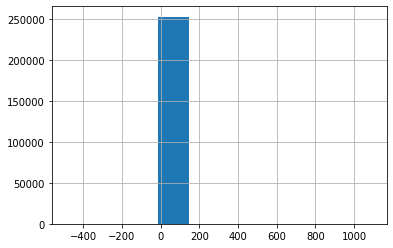

In [13]:
new_train_df['ftimediff'].hist()

In [51]:
new_train_df['ftimediff'].abs().sort_values(ascending=False).head(20)

245397    1090.0
242007     762.0
242831     636.0
69514      593.0
124869     541.0
28294      483.0
241702     468.0
28561      434.0
242272     433.0
30637      381.0
225166     316.0
66647      273.0
179156     271.0
13024      215.0
241090     192.0
195615     174.0
9566       144.0
228193     141.0
223312     139.0
6232       137.0
Name: ftimediff, dtype: float64

In [18]:
new_train_df

,site_path_timestamp,id,fx,fy,ftimediff
0,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,0,114.20202834805966,156.6588136425817,-5.0
1,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,1,113.38601022471394,156.1064101579978,4.0
2,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,2,111.65123899028795,155.1443630065837,6.0
3,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,3,109.76246531620754,154.42622368168375,5.0
4,5a0546857ecc773753327266_5e1580d1f4c3420006d52...,4,108.29899435430356,153.92184009812655,-6.0
...,...,...,...,...,...
252807,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252807,128.8176867773375,108.83844149596688,0.0
252808,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252808,131.2518952441521,111.02916355921022,-3.0
252809,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252809,132.17416855899293,111.87550933426647,9.0
252810,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...,252810,134.49539008191215,114.15798207145465,-2.0


In [19]:
train_df = from_pickle('../input/2kaido_wifi_dataset_v3/train_10000_7.pkl')
train_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,y,itimestamp,ix,iy,floor,floor_str,path,site_id,timediff,itimediff
0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,156.84224,1578466134278,113.615385,156.63479750000002,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45
1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,156.84224,1578466136278,112.655885,156.35820750000002,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12
2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,156.84224,1578466138278,111.93625999999999,156.150765,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29
3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,156.84224,1578466140278,110.97676,155.874175,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72
4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,...,154.62952,1578466142278,110.01726,155.597585,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252807,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,90ef6526fa145d95dc065edc3b3a3193406f3ee4,...,107.01164,1573892866000,128.92521,109.01805999999999,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38
252808,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,da39a3ee5e6b4b0d3255bfef95601890afd80709,022a370e1c578e795c972b955120606c5dcc6cc8,...,111.526085,1573892868000,130.64579999999998,110.52287499999998,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,1098,126
252809,1833

In [22]:
train_df = pd.concat([train_df, new_train_df[['fx','fy']]], axis=1)
train_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,ix,iy,floor,floor_str,path,site_id,timediff,itimediff,fx,fy
0,356d66c73c423be835bd5d07cb1ebdfa821d8e23,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,4e601619b7c7d9df8d61490ad2c134f08ea01d61,c3513a636d1a813db081a2ffc33f297b4fefe28d,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,113.615385,156.63479750000002,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-1545,-45,114.20202834805966,156.6588136425817
1,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,c3513a636d1a813db081a2ffc33f297b4fefe28d,990847ae755de95a44c7b1be54e66f4e56fdc7f4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,112.655885,156.35820750000002,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-3512,-12,113.38601022471394,156.1064101579978
2,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,c3513a636d1a813db081a2ffc33f297b4fefe28d,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,4e601619b7c7d9df8d61490ad2c134f08ea01d61,2ce029b3a3dea973a44bf0587be5e2b93a74e5f1,b14c56d7cd73a5b026fc118c671e24dc2ba2558b,3fa90121039c7b6e24ae985d228e0366ae15fba4,3745dc080c9396d2317f4c05d7141c1df83acf9d,...,111.93625999999999,156.150765,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-5471,29,111.65123899028795,155.1443630065837
3,356d66c73c423be835bd5d07cb1ebdfa821d8e23,f44fa6118fed7198296c8b45b2f2684903d99620,5a368e0bd5050bdb4653dc39c86bee1fd2b8aeb7,990847ae755de95a44c7b1be54e66f4e56fdc7f4,da39a3ee5e6b4b0d3255bfef95601890afd80709,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,3fa90121039c7b6e24ae985d228e0366ae15fba4,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,110.97676,155.874175,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,-7428,72,109.76246531620754,154.42622368168375
4,f44fa6118fed7198296c8b45b2f2684903d99620,356d66c73c423be835bd5d07cb1ebdfa821d8e23,990847ae755de95a44c7b1be54e66f4e56fdc7f4,c3513a636d1a813db081a2ffc33f297b4fefe28d,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8aed75f7c344e6a3d4916750029dd4ee47c1e7c5,...,110.01726,155.597585,-1.0,B1,5e1580d1f4c3420006d520e4,5a0546857ecc773753327266,7401,105,108.29899435430356,153.92184009812655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252807,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,18336f0964fbd470a2ee7116d33b96946c633999,040667e2fdd3a9bbb54e970c430ad6f08416c52e,072159287058774aa9b450c9163129b309bc982b,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,90ef6526fa145d95dc065edc3b3a3193406f3ee4,...,128.92521,109.01805999999999,6.0,F7,5dcfb393878f3300066c70a6,5dc8cea7659e181adb076a3f,-2224,38,128.8176867773375,108.83844149596688
252808,18336f0964fbd470a2ee7116d33b96946c633999,18336f0964fbd470a2ee7116d33b96946c633999,072159287058774aa9b450c9163129b309bc982b,072159287058774aa9b450c9163129b309bc982b,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,040667e2fdd3a9bbb54e970c430ad6f08416c52e,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea9e102c49dbc834b1059c5e8b5dc4a017a82dff,da39a3ee5e6b4b0d3255bfef95601890afd80709,022a370e1c578e795c972b955120606c5dcc6cc8,...,130.64579999999998,110.52287499999998,6.0,F7,5dcfb393878f3300066c70

<AxesSubplot:>

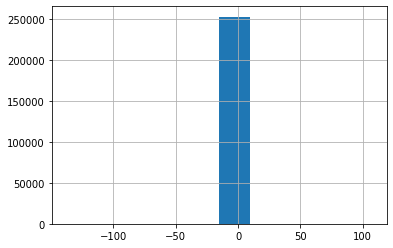

In [31]:
(train_df['iy'].astype(float) - train_df['fy'].astype(float)).hist()

In [46]:
(train_df['ix'].astype(float) - train_df['fx'].astype(float)).abs().sort_values(ascending=False).head(40)

160947    167.741942
160946    144.384096
160097    127.780541
160945    123.182227
160096    106.413485
160944    103.522563
165472     95.617169
160095     87.308230
160943     85.745996
165471     76.679888
160942     71.224401
160094     70.448430
60577      67.228443
252139     65.998292
128017     64.076512
36005      61.458943
252138     59.865521
165470     59.504318
160941     57.820782
160093     55.701810
110840     55.462128
252137     52.454909
136853     52.073321
12985      50.761957
110839     50.127848
36004      49.959879
139097     49.873097
146892     47.054245
47427      46.935253
60576      45.593570
136852     45.304292
12984      45.196150
160940     44.941547
252136     44.906727
110838     44.834544
165469     44.767042
128016     44.332208
160092     42.721613
47426      40.755150
146891     40.746762
dtype: float64

In [54]:
(train_df['x'].astype(float) - train_df['fx'].astype(float)).abs().sort_values(ascending=False).head(40)

160947    167.741942
160946    144.384096
160097    127.780541
160945    123.182227
160096    106.413485
160944    103.522563
165472     95.617169
160095     87.308230
160943     85.745996
165471     76.679888
160942     71.224401
160094     70.448430
60577      67.228443
252139     65.998292
128017     64.076512
36005      61.458943
252138     59.865521
165470     59.504318
160941     57.820782
160093     55.701810
110840     55.462128
252137     52.454909
136853     52.073321
12985      51.385325
110839     50.127848
36004      49.959879
139097     49.873097
18294      47.513119
20422      47.479105
146892     47.054245
47427      46.935253
12984      46.754571
60576      45.593570
136852     45.304292
160940     44.941547
252136     44.906727
110838     44.834544
165469     44.767042
18293      44.591788
128016     44.332208
dtype: float64

<AxesSubplot:>

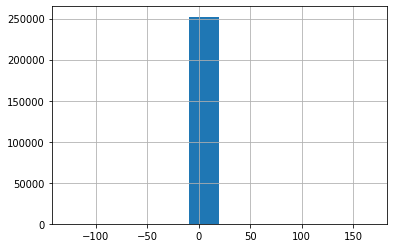

In [33]:
(train_df['x'].astype(float) - train_df['fx'].astype(float)).hist()

In [23]:
import os
os.makedirs('../input/2kaido_wifi_dataset_v5', exist_ok=True)

In [28]:
to_pickle('../input/2kaido_wifi_dataset_v5/train_10000_7.pkl', train_df)

In [26]:
test_df = from_pickle('../input/2kaido_wifi_dataset_v3/test_10000_7.pkl')
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_96,timediff_97,timediff_98,timediff_99,timestamp,real_timestamp,path,site_id,timediff,site_path_timestamp
0,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,ab150ecf6d972b476aeab16317bed6189d9f7cce,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,01e78c97f2c04cdbc7c4159158bb125a9bb558ff,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,1251.0,1228.0,877.0,135.0,0000000000009,1578474564146,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-2331,5a0546857ecc773753327266_046cfa46be49fc1083481...
1,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5532.0,5529.0,5532.0,5350.0,0000000009017,1578474573154,046cfa46be49fc10834815c6,5a0546857ecc773753327266,4287,5a0546857ecc773753327266_046cfa46be49fc1083481...
2,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,859.0,853.0,5739.0,3633.0,0000000009017,1578474573154,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-491,5a0546857ecc773753327266_046cfa46be49fc1083481...
3,7182afc4e5c212133d5d7d76eb3df6c24618302b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5741.0,2950.0,2949.0,2951.0,0000000009017,1578474573154,046cfa46be49fc10834815c6,5a0546857ecc773753327266,1827,5a0546857ecc773753327266_046cfa46be49fc1083481...
4,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,7649.0,7373.0,1883.0,1422.0,0000000015326,1578474579463,046cfa46be49fc10834815c6,5a0546857ecc773753327266,612,5a0546857ecc773753327266_046cfa46be49fc1083481...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37434,8e69018f6343506344ab13646ccd9447fc2ffb19,8e69018f6343506344ab13646ccd9447fc2ffb19,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,0f927dce74ec3475c7a39299e5bffab222ca665d,0eb4ecd03a3128e62bdff60e6f686d88e783441e,...,1860.0,2409.0,2410.0,1714.0,0000000090895,1573731151613,fd64de8c4a2fc5ebb0e9f412,5dc8cea7659e181adb076a3f,1344,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...
37435,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,c72257cf75d6a411225948bbc4e37ad554e7beda,8e69018f6343506344ab13646ccd9447fc2ffb19,da39a3ee

In [27]:
to_pickle('../input/2kaido_wifi_dataset_v5/test_10000_7.pkl', test_df)